# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#pd.get_dummy與sklearn 的 OneHotEncoder皆能執行獨熱編碼
# pd.get_dummy輸入是一維array-like，輸出是dataframe
#sklearn 的 OneHotEncoder輸入與輸出都是二維array
#然而fit transform後不是二維array，因此這裡會先轉成二維矩陣再輸入給sklearn 的 OneHotEncoder執行獨熱編碼
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()      #將文字編碼成數字
MMEncoder = MinMaxScaler()     #每個特徵的數字範圍不同，將特徵正規化到範圍再0~1之間
for c in df.columns:
    df[c] = df[c].fillna(-1)        #nan的地方用-1補
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))  #用.reshape(-1, 1)把df[c].valuese改成二維矩陣
                                      #MMEncoder.fit_transform之輸入必須是二維矩陣
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to floa

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [4]:
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(222, 10)
(223, 10)
(446, 10)


# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [5]:
"""
https://www.cnblogs.com/pinard/p/6160412.html

n_estimators: 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数

min_samples_split:如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分

min_samples_leaf:这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。

max_depth:决策树最大深度，如果模型样本量多，特征也多的情况下，推荐限制这个最大深度

bootstrap:參數默認True，True代表采用有放回的隨機抽樣技術。通常，這個參數不會被我們設置為False。
"""

'\nhttps://www.cnblogs.com/pinard/p/6160412.html\n\nn_estimators: 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数\n\nmin_samples_split:如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分\n\nmin_samples_leaf:这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。\n\nmax_depth:决策树最大深度，如果模型样本量多，特征也多的情况下，推荐限制这个最大深度\n\nbootstrap:參數默認True，True代表采用有放回的隨機抽樣技術。通常，這個參數不會被我們設置為False。\n'

In [6]:
#enc.transform(ndata) 不是array形式
              #必須加上to array ，
              #print(enc.transform(ndata).toarray())才能以矩陣型態印出

In [7]:
"""
max_iter  #最大训练迭代次数，这个数设置太小，会导致没有收敛，精确度很低

solver    #优化算法选择参数，
          #lbfgs：拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
          #https://zhuanlan.zhihu.com/p/35182003
"""

'\nmax_iter  #最大训练迭代次数，这个数设置太小，会导致没有收敛，精确度很低\n\nsolver    #优化算法选择参数，\n          #lbfgs：拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。\n          #https://zhuanlan.zhihu.com/p/35182003\n'

In [8]:
"""
https://www.maxlist.xyz/2019/03/28/ml-100days-2/
葉編碼:
1.將決策樹的葉點編號(1leaf indices)當做新特徵
2.把葉點編號(正整數，2、3、4、....)轉成獨熱編碼
2.再用邏輯回歸合併預測

原本的data有N個特徵
經過隨機森林運算後的結果，每個樹會有很多個分支與葉點，
因此，整個模型所有的決策樹會得到M個葉點
把這M個葉點當成新特徵X，輸入邏輯回歸，用來預測label y
"""

'\nhttps://www.maxlist.xyz/2019/03/28/ml-100days-2/\n葉編碼:\n1.將決策樹的葉點編號(1leaf indices)當做新特徵\n2.把葉點編號(正整數，2、3、4、....)轉成獨熱編碼\n2.再用邏輯回歸合併預測\n\n原本的data有N個特徵\n經過隨機森林運算後的結果，每個樹會有很多個分支與葉點，\n因此，整個模型所有的決策樹會得到M個葉點\n把這M個葉點當成新特徵X，輸入邏輯回歸，用來預測label y\n'

In [9]:
# 第一步:使用隨機森林的擬合結果之葉點, 將這些葉點視為新的特徵
#把這些葉點當新特徵做獨熱編碼就能得到葉編碼 (*.apply) 
#最後把葉編碼結果當成特徵X，輸入邏輯斯迴歸，與原始的label y，做預測比較
rf = RandomForestClassifier(n_estimators=40, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)    #rf是隨機森林分類器
onehot = OneHotEncoder()                                                    #onehot是獨熱編碼編碼器 
lr = LogisticRegression(solver='lbfgs', max_iter=1000)                      #lr是羅吉斯回歸分類器或迴歸器  

In [10]:
"""
https://blog.csdn.net/w952470866/article/details/78987265
apply(X)	  Apply trees in the forest to X, return leaf indices.将森林中的树应用到X，返回树叶索引。
fit(X, y[, sample_weight])	    Build a forest of trees from the training set (X, y).

隨機森林的葉點編號不需要加上[:, :, 0], 直接用rf.apply()調用，即可得到葉點編號leaf indices
因為葉點編號是正整數(2、3、4....)，接著使用獨熱編碼將葉點編號轉換，就是所謂的葉編碼了 
 
"""
#rf.fit(train_X, train_Y)   #用fit完成隨機森林分類器的訓練，訓練結果的分類器就叫rf


'\nhttps://blog.csdn.net/w952470866/article/details/78987265\napply(X)\t  Apply trees in the forest to X, return leaf indices.将森林中的树应用到X，返回树叶索引。\nfit(X, y[, sample_weight])\t    Build a forest of trees from the training set (X, y).\n\n隨機森林的葉點編號不需要加上[:, :, 0], 直接用rf.apply()調用，即可得到葉點編號leaf indices\n因為葉點編號是正整數(2、3、4....)，接著使用獨熱編碼將葉點編號轉換，就是所謂的葉編碼了 \n \n'

In [11]:
#rf.apply(train_X)      #用apply，就能得到輸入train_X之後，每個葉點的數值(leaf indices，決策樹的編號)
                       #由邊號是正整數7、8、11.....可知
                       #可以把葉點數值再編碼成獨熱編碼，變成稀疏矩陣也能增加特徵

In [12]:
#print(train_X.shape)
#print(train_X[:5])

In [13]:

#由這邊可知，原本的data train_X只有10個特徵
#如果使用隨機森林的葉點編號，將變成n_estimators個特徵
#rf.apply(train_X).shape   #用apply會得到leaf indices，這代表來自哪顆樹
                          #n_estimators是森林里树的数量，
                          #因此，n_estimators=20->新特徵共20個(由矩陣column數可知)，
                          #leaf indices代表的是葉點標號，所以不會0~19都出現

In [14]:
"""
葉編碼:
1.將決策樹的葉點編號(1leaf indices)當做新特徵
2.把葉點編號(正整數，2、3、4、....)轉成獨熱編碼
2.再用邏輯回歸合併預測
"""
rf.fit(train_X, train_Y)              #用fit完成隨機森林分類器的訓練，訓練結果的分類器就叫rf
#leaf_train_X=onehot.fit_transform(rf.apply(train_X))        #隨機森林的葉點編號可由rf.apply(train_X)得到 
                                                             #把葉點編號輸入onehot.fit_transform()，就完成對葉點編號的獨熱編碼
                                                             #編碼結果是leaf_train_X，這就是葉編碼結果

        
onehot.fit(rf.apply(train_X))                                #trainning set之隨機森林的葉點編號可由rf.apply(train_X)得到 
                                                             #將此輸入onehot.fit()就能完成隨機森林葉編碼器的訓練
    
    
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)             #接著要用val set完成對羅吉斯回歸的訓練
                                                             #因此將val set之隨機森林的葉點編號，由rf.apply(train_X)得到後
                                                             #把val set的葉編碼當新特徵，以輸入lr.fit()就能完成羅吉斯回歸的訓練

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
val_Y.value_counts()

0    143
1     80
Name: Survived, dtype: int64

In [16]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:, 1]   #[n,1]是第n個index被預測為1的機率；[n,0]是第n個index被預測為0的機率
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)            #輸入:真實的標籤test_Y，判斷是1的機率=pred_rf_lr (輸入都要矩陣形式)
                                                                   #輸出: fpr(false alarm probability), tpr(detected probability), threshold
# 將隨機森林結果輸出
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

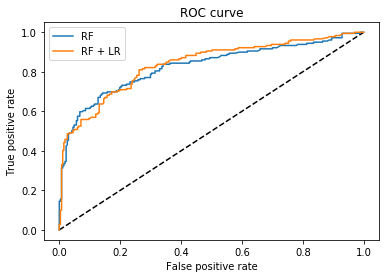

In [18]:
import matplotlib.pyplot as plt
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ANS.fpr較小的時候，只有RF會比較好(因為tpr較高；ROC曲線下面積愈大代表準確度愈高)
    fpr較大的時候，RF+LF會比較好(因為tpr較高；ROC曲線下面積愈大代表準確度愈高)